## SPEAKER RECOGNITION

In [1]:
import os
import shutil
import librosa
import wave

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import soundfile as sf
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from IPython.display import Audio, display

In [2]:
train_dir = os.path.join('ROBOVOX_SP_CUP_2024', 'data', 'single-channel', 'enrollment')
speaker_folders = os.listdir(train_dir)

## Data Visualization

In [3]:
# open wave file
audio = os.path.join(train_dir, 'spk_11', 'spk_11-11_22_1_0_d4_ch5.wav')
wf = wave.open(audio,'r')
display(Audio(audio))

print("Number of channels", wf.getnchannels())
print("Sample width", wf.getsampwidth())
print("Frame rate.", wf.getframerate())
print("Number of frames", wf.getnframes())
print("parameters:", wf.getparams())

Number of channels 1
Sample width 2
Frame rate. 16000
Number of frames 85683
parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=85683, comptype='NONE', compname='not compressed')


C:\Users\Nilupulee\AppData\Local\Temp\ipykernel_5012\3223606671.py:17: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


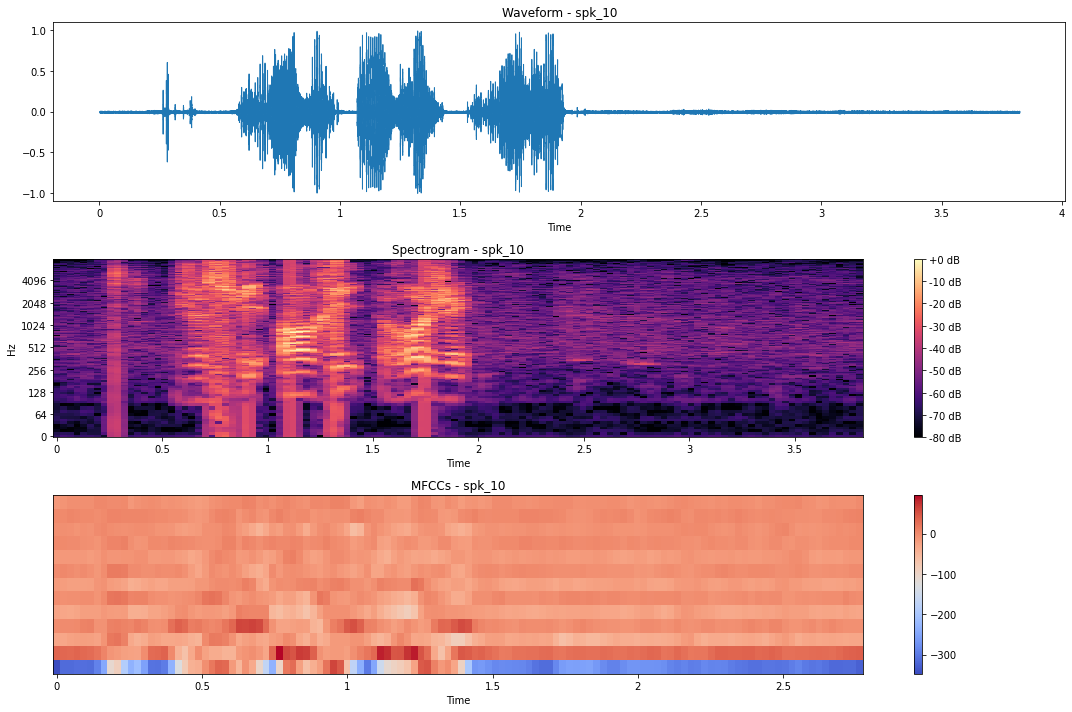

C:\Users\Nilupulee\AppData\Local\Temp\ipykernel_5012\3223606671.py:17: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


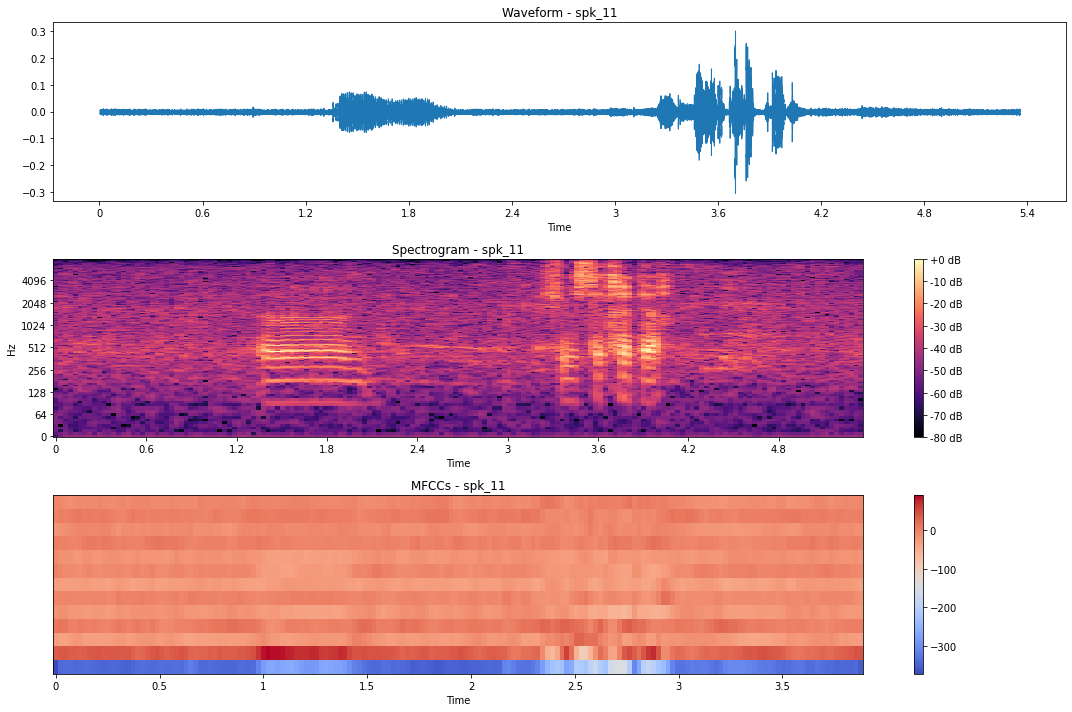

In [4]:
# Function to plot the waveform, spectrogram, and MFCCs
def plot_audio_features(audio_path):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Extract speaker name from the file path
    speaker_name = os.path.basename(audio_path).split('-')[0]

    # Plot the waveform
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {speaker_name}')

    # Plot the spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - {speaker_name}')

    # Plot the MFCCs
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCCs - {speaker_name}')

    plt.tight_layout()
    plt.show()

# Paths to the combined audio files
audio_paths = [
    os.path.join(train_dir, 'spk_10', 'spk_10-10_21_0_0_d2_ch5.wav'),
    os.path.join(train_dir, 'spk_11', 'spk_11-11_22_1_0_d4_ch5.wav'),
]

# Plot features for each audio file
for audio_path in audio_paths:
    plot_audio_features(audio_path)


## Feature Extraction

In [5]:
def extract_features(train_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(train_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=None, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                
                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)
                
                features.append(mfccs.T)
                labels.append(i)

    return np.array(features), np.array(labels)

# Extract features and labels
X, y = extract_features(train_dir, speaker_folders)

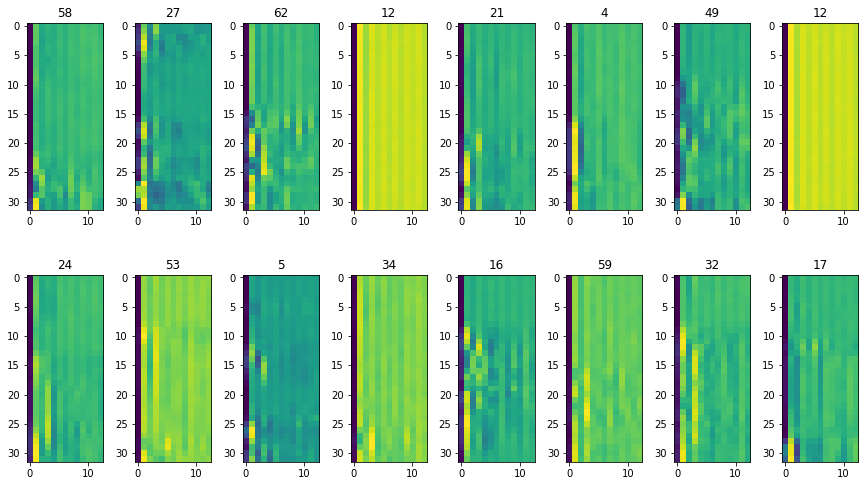

In [6]:
fig, axes = plt.subplots(2,8, figsize=(12, 7))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(X.shape[0])
    
    # Display the image
    ax.imshow(X[random_index])
    
    # Display the label above the image
    ax.set_title(y[random_index])

In [7]:
print(y)

[ 0  0  0  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7
  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15
 16 16 16 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22 22 23 23 23
 24 24 24 25 25 25 26 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31
 32 32 32 33 33 33 34 34 34 35 35 35 36 36 36 37 37 37 38 38 38 39 39 39
 40 40 40 41 41 41 42 42 42 43 43 43 44 44 44 45 45 45 46 46 46 47 47 47
 48 48 48 49 49 49 50 50 50 51 51 51 52 52 52 53 53 53 54 54 54 55 55 55
 56 56 56 57 57 57 58 58 58 59 59 59 60 60 60 61 61 61 62 62 62 63 63 63
 64 64 64 65 65 65 66 66 66 67 67 67 68 68 68 69 69 69 70 70 70 71 71 71
 72 72 72 73 73 73 74 74 74]


## Model Set Up

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [9]:
# Encode labels with explicit classes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_encoder.classes_ = np.array(speaker_folders)

print(X.shape)
print(y.shape)
# Split the data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# Print the shapes of training and validation data
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)

(225, 32, 13)
(225,)
Training Data Shape: (191, 32, 13)
Validation Data Shape: (34, 32, 13)


In [10]:
# Create a dictionary to map numeric labels to original names
label_to_name = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

# Map numeric labels to original names in y
y_original_names = np.vectorize(label_to_name.get)(y)

print(y_original_names)

['spk_10' 'spk_10' 'spk_10' 'spk_11' 'spk_11' 'spk_11' 'spk_12' 'spk_12'
 'spk_12' 'spk_13' 'spk_13' 'spk_13' 'spk_14' 'spk_14' 'spk_14' 'spk_15'
 'spk_15' 'spk_15' 'spk_16' 'spk_16' 'spk_16' 'spk_17' 'spk_17' 'spk_17'
 'spk_18' 'spk_18' 'spk_18' 'spk_19' 'spk_19' 'spk_19' 'spk_2' 'spk_2'
 'spk_2' 'spk_20' 'spk_20' 'spk_20' 'spk_21' 'spk_21' 'spk_21' 'spk_22'
 'spk_22' 'spk_22' 'spk_23' 'spk_23' 'spk_23' 'spk_24' 'spk_24' 'spk_24'
 'spk_25' 'spk_25' 'spk_25' 'spk_26' 'spk_26' 'spk_26' 'spk_27' 'spk_27'
 'spk_27' 'spk_28' 'spk_28' 'spk_28' 'spk_29' 'spk_29' 'spk_29' 'spk_3'
 'spk_3' 'spk_3' 'spk_30' 'spk_30' 'spk_30' 'spk_31' 'spk_31' 'spk_31'
 'spk_32' 'spk_32' 'spk_32' 'spk_33' 'spk_33' 'spk_33' 'spk_34' 'spk_34'
 'spk_34' 'spk_35' 'spk_35' 'spk_35' 'spk_36' 'spk_36' 'spk_36' 'spk_37'
 'spk_37' 'spk_37' 'spk_38' 'spk_38' 'spk_38' 'spk_39' 'spk_39' 'spk_39'
 'spk_4' 'spk_4' 'spk_4' 'spk_40' 'spk_40' 'spk_40' 'spk_41' 'spk_41'
 'spk_41' 'spk_42' 'spk_42' 'spk_42' 'spk_43' 'spk_43' 'spk_

## Training

In [11]:
# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(speaker_folders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/100
8/8 [==============================] - 0s 27ms/step - loss: 1.5235 - accuracy: 0.6000 - val_loss: 1.2128 - val_accuracy: 0.6765
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 1.4635 - accuracy: 0.6356 - val_loss: 1.1589 - val_accuracy: 0.6765
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 1.3787 - accuracy: 0.6444 - val_loss: 1.0826 - val_accuracy: 0.6471
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 1.4220 - accuracy: 0.6489 - val_loss: 1.0336 - val_accuracy: 0.8235
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 1.3983 - accuracy: 0.6400 - val_loss: 1.1926 - val_accuracy: 0.7941
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 1.8141 - accuracy: 0.5644 - val_loss: 1.3831 - val_accuracy: 0.6471
Early stopping triggered at epoch 6


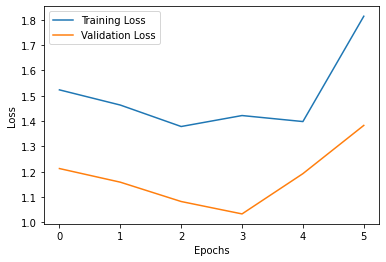

In [24]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X, y, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

# Check if EarlyStopping triggered
if early_stopping.stopped_epoch > 0:
    print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
else:
    print("Training completed without early stopping")

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6/6 [==============================] - 0s 12ms/step
Test Evaluation Accuracy: 0.6858638743455497
Weighted F1 Score: 0.6878742548899617


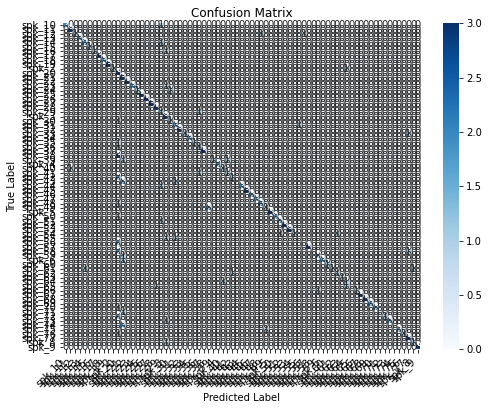

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_train)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_train)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [26]:
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_val, y_val))

6/6 [==============================] - 0s 13ms/step - loss: 1.4214 - accuracy: 0.6859
[1.4213664531707764, 0.6858638525009155]
2/2 [==============================] - 0s 10ms/step - loss: 1.0336 - accuracy: 0.8235
[1.033586859703064, 0.8235294222831726]


## Testing

In [27]:
test_dir = os.path.join('ROBOVOX_SP_CUP_2024', 'data', 'single-channel', 'test')
test_labels = os.listdir(test_dir)
print(test_labels[:10])

['0000f88619.wav', '000f6d0072.wav', '001dd0cb47.wav', '001f7db31a.wav', '001f86a5bf.wav', '002724b7ea.wav', '0042734703.wav', '00465a38b0.wav', '004adba134.wav', '005ae9cb2b.wav']


In [28]:
# open wave file
test_audio = os.path.join(test_dir, '000f6d0072.wav')
test_wf = wave.open(test_audio,'r')
display(Audio(test_audio))

print("Number of channels", test_wf.getnchannels())
print("Sample width", test_wf.getsampwidth())
print("Frame rate.", test_wf.getframerate())
print("Number of frames", test_wf.getnframes())
print("parameters:", test_wf.getparams())

Number of channels 1
Sample width 2
Frame rate. 16000
Number of frames 41746
parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=41746, comptype='NONE', compname='not compressed')


In [29]:
def extract_features_test(test_dir, test_labels):
    features = []
    labels = []

    for filename in test_labels:
        if filename.endswith(".wav"):
            file_path = os.path.join(test_dir, filename)
            audio, sr = librosa.load(file_path, sr=None, duration=1)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                
            # Normalize MFCC features
            mfccs = StandardScaler().fit_transform(mfccs)
                
            features.append(mfccs.T)
            labels.append(test_labels)

    return np.array(features), np.array(labels)

In [30]:
X_test, y_test = extract_features_test(test_dir, test_labels)

In [31]:
# Predict probabilities for the training dataset
predictions = model.predict(X_test, verbose=0)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Map numeric labels to original names 
predicted_names = np.vectorize(label_to_name.get)(predicted_labels)

# Print or use the predicted labels as needed
for i in range(X_test.shape[0]):
    print(predicted_names[i], ' ', test_labels[i][:-4])


spk_40   0000f88619
spk_30   000f6d0072
spk_44   001dd0cb47
spk_36   001f7db31a
spk_36   001f86a5bf
spk_41   002724b7ea
spk_29   0042734703
spk_21   00465a38b0
spk_64   004adba134
spk_36   005ae9cb2b
spk_68   006a19dfc1
spk_36   006ce8656f
spk_29   00806ad24b
spk_20   0086c2506c
spk_21   008a2d1b07
spk_36   008a7764f2
spk_29   0094b5dfc9
spk_20   009ba16c1a
spk_29   00a49d6b07
spk_21   00a794c50e
spk_55   00a931d755
spk_20   00a99c3526
spk_40   00b83bd14a
spk_51   00b8e3ede3
spk_50   00b9eb2548
spk_41   00cb4de6c8
spk_21   00ceb6128b
spk_36   00d04a8940
spk_20   00d22594fc
spk_40   00db58f060
spk_29   00f0a14e19
spk_51   00f242e1eb
spk_51   00f2a5affd
spk_36   00f6eb9aee
spk_29   00f9fa8a7d
spk_21   0108e00b88
spk_21   0114acfca1
spk_20   01184d45ed
spk_51   011b079e27
spk_20   01228119f5
spk_21   0124c59443
spk_40   0125ca27d4
spk_47   012800edf3
spk_2   01310bec72
spk_30   0142035f16
spk_21   014521e2a7
spk_20   0147917989
spk_51   0147bd89f3
spk_53   014a9ec64b
spk_21   01501469fe
s